In [2]:
! pip install kaggle --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other




  0%|          | 0.00/25.7M [00:00<?, ?B/s]
  4%|▍         | 1.00M/25.7M [00:01<00:31, 833kB/s]
  8%|▊         | 2.00M/25.7M [00:01<00:15, 1.65MB/s]
 12%|█▏        | 3.00M/25.7M [00:01<00:09, 2.38MB/s]
 16%|█▌        | 4.00M/25.7M [00:01<00:07, 3.24MB/s]
 19%|█▉        | 5.00M/25.7M [00:01<00:05, 4.13MB/s]
 23%|██▎       | 6.00M/25.7M [00:02<00:04, 5.01MB/s]
 27%|██▋       | 7.00M/25.7M [00:02<00:03, 5.76MB/s]
 31%|███       | 8.00M/25.7M [00:02<00:02, 6.42MB/s]
 35%|███▌      | 9.00M/25.7M [00:02<00:02, 6.80MB/s]
 39%|███▉      | 10.0M/25.7M [00:02<00:02, 7.16MB/s]
 43%|████▎     | 11.0M/25.7M [00:02<00:02, 7.51MB/s]
 47%|████▋     | 12.0M/25.7M [00:02<00:01, 7.77MB/s]
 51%|█████     | 13.0M/25.7M [00:02<00:01, 7.93MB/s]
 54%|█████▍    | 14.0M/25.7M [00:03<00:01, 7.30MB/s]
 58%|█████▊    | 15.0M/25.7M [00:03<00:01, 6.40MB/s]
 62%|██████▏   | 16.0M/25.7M [00:03<00:01, 5.48MB/s]
 66%|██████▌   | 17.0M/25.7M [00:04<00:03, 2.73MB/s]
 74%|███████▍  | 19.0M/25.7M [00:04<00:01, 4.56MB/s]
 7

In [5]:
import zipfile
with zipfile.ZipFile("imdb-dataset-of-50k-movie-reviews.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [11]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdulmunim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abdulmunim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abdulmunim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
%matplotlib inline

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [16]:
# Vectorization and Model related
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
# let's try Naive Bayes and Logistic Regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

In [17]:
df = pd.read_csv("data/IMDB Dataset.csv")

In [18]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [19]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [20]:
# Preprocessing

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text).lower()
    # Tokenize words
    words = nltk.word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    cleaned_words = [
        lemmatizer.lemmatize(word) for word in words if word not in stop_words
    ]
    return " ".join(cleaned_words)

In [21]:
df["cleaned_review"] = df["review"].apply(clean_text)

In [22]:
# Encode the sentiment
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

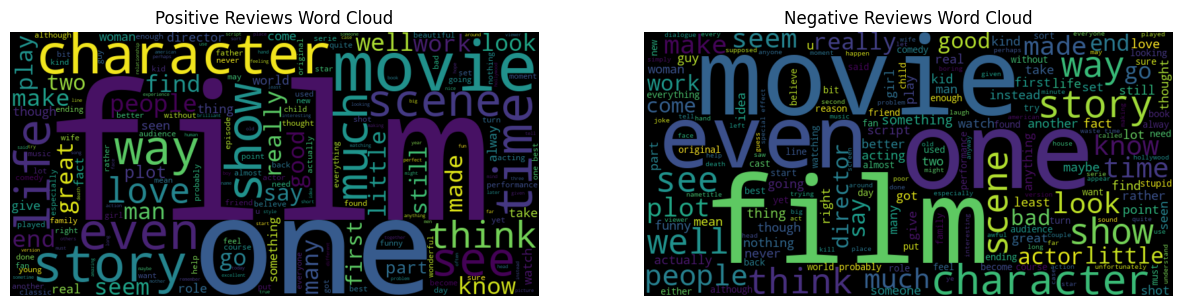

In [23]:
# For EDA (Let's do som fancy stuff)

from wordcloud import WordCloud

# nositive reviews
positive_text = " ".join(df[df['sentiment'] == 1]['cleaned_review'])
wordcloud_pos = WordCloud(width=800, height=400).generate(positive_text)

# Negative reviews
negative_text = " ".join(df[df['sentiment'] == 0]['cleaned_review'])
wordcloud_neg = WordCloud(width=800, height=400).generate(negative_text)

# Plotting
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

Text(0, 0.5, 'Frequency')

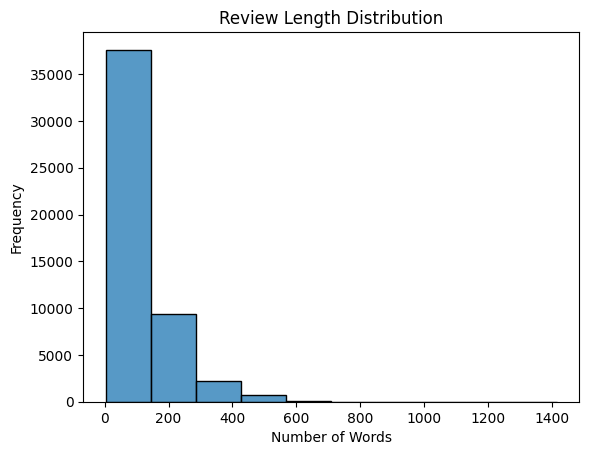

In [24]:
# Let's see the reveiw lengths

df["review_length"] = df["cleaned_review"].apply(lambda x: len(x.split()))
sns.histplot(df["review_length"], bins=10)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")


In [25]:
# Feature Extraction

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["cleaned_review"])
y = df["sentiment"].values

In [27]:
# Train Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
# Model

# 1. Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [29]:
# 2. Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [30]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}\n")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5000
           1       0.85      0.86      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Naive Bayes Accuracy: 0.8540



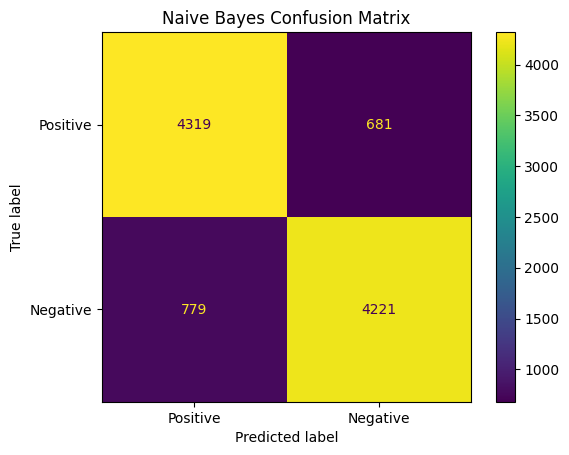

In [32]:
evaluate_model(nb, X_test, y_test, "Naive Bayes")

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Logistic Regression Accuracy: 0.8907



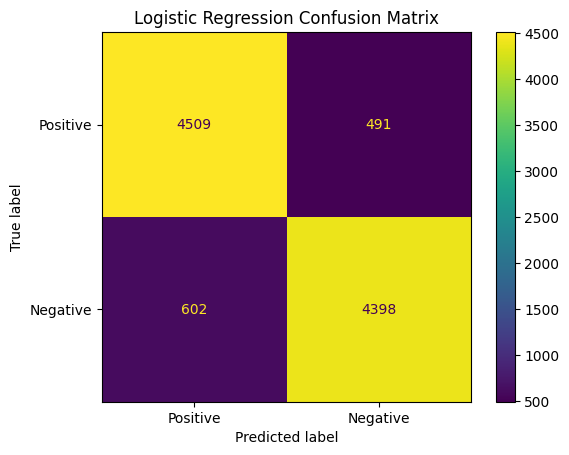

In [33]:
evaluate_model(lr, X_test, y_test, "Logistic Regression")

In [34]:
# Hyperparameter Tuning for Logistic Regression

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [35]:
print(f"Best Parameters: {grid_lr.best_params_}")
best_lr_model = grid_lr.best_estimator_

Best Parameters: {'C': 1, 'solver': 'liblinear'}


Tuned Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Tuned Logistic Regression Accuracy: 0.8907



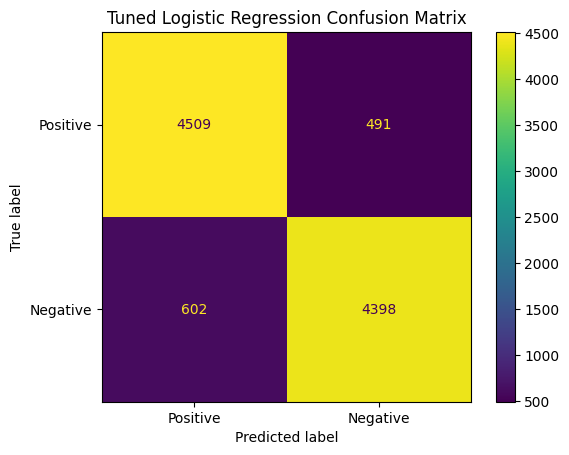

In [36]:
evaluate_model(best_lr_model, X_test, y_test, "Tuned Logistic Regression")